In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Plot 1: Show times of different similarity metrics

In [2]:
# Load accuracy .csv and times.csv
time_path = '../../results/1_sim_metrics/mini_train/times.csv'
acc_path = '../../results/1_sim_metrics/accuracy.csv'

def get_max_n(row):
    return max(row['n_dets'],row['n_trks'])

def compute_fps(row):
    return 1000000000./row['time_ns']
    
time_df = pd.read_csv(time_path)
time_df['n_max'] = time_df.apply(get_max_n, axis=1)
time_df['fps'] = time_df.apply(compute_fps, axis=1)
acc_df = pd.read_csv(acc_path)

split='mini_train'
split_df = acc_df[acc_df['split']==split]

In [3]:
dist_time_df = time_df[time_df['config'].str.contains("_dist")]
iou_time_df = time_df[time_df['config'].str.contains("_iou3d")]
giou_time_df = time_df[time_df['config'].str.contains("_giou3d")]


dist
0.025111168021671827
39.8229185968954
0.571158291
1.7508281255082052
323

iou3d
0.7859217021486069
1.2723913810575929
3.435672333
0.2910638451737359
323

giou3d
2.6959052713560374
0.37093291467804473
12.333493052
0.08108003108153046
323



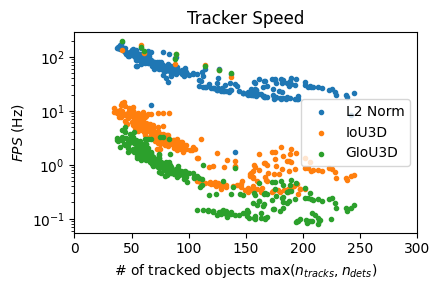

In [15]:

# Original plot, time vs n
# fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4.5,4.5)) # , gridspec_kw={'width_ratios': [2, 1]}
# axs.scatter(dist_time_df['n_max'],dist_time_df['time_ns']/1000000000,marker='.')
# axs.scatter(iou_time_df['n_max'],iou_time_df['time_ns']/1000000000,marker='.')
# axs.scatter(giou_time_df['n_max'],giou_time_df['time_ns']/1000000000,marker='.')
# axs.set_xlim([0,250])
# axs.set_title('Tracker Loop Times')
# axs.set_xlabel('max($n_{tracks},n_{dets}$)')
# axs.set_ylabel('Tracker Loop Interval $\Delta t$ (s)')
# axs.legend(['L2 Norm','IoU3D','GIoU3D'])

# New plot, speed vs n on log scale
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4.5,3.)) # , gridspec_kw={'width_ratios': [2, 1]}
axs.scatter(dist_time_df['n_max'],dist_time_df['fps'],marker='.')
axs.scatter(iou_time_df['n_max'],iou_time_df['fps'],marker='.')
axs.scatter(giou_time_df['n_max'],giou_time_df['fps'],marker='.')
axs.set_xlim([0,300])
axs.set_title('Tracker Speed')
axs.set_xlabel('# of tracked objects max($n_{tracks},n_{dets}$)')
axs.set_ylabel('$FPS$ (Hz)')
axs.set_yscale('log')
axs.legend(['L2 Norm','IoU3D','GIoU3D'])


plt.savefig('nuscenes_results_1.png')

print("dist")
print(np.mean(dist_time_df['time_ns']/1000000000))
print(1000000000/np.mean(dist_time_df['time_ns']))
print(np.max(dist_time_df['time_ns']/(1000000000)))
print(1000000000/np.max(dist_time_df['time_ns']))
# print(np.mean(dist_time_df['time_ns']/(dist_time_df['n_max']*1000000000)))
# print(np.max(dist_time_df['time_ns']/(dist_time_df['n_max']*1000000000)))
print(len(dist_time_df['time_ns']))
print()

print("iou3d")
print(np.mean(iou_time_df['time_ns']/1000000000))
print(1000000000/(np.mean(iou_time_df['time_ns'])))
print(np.max(iou_time_df['time_ns']/(1000000000)))
print(1000000000./(np.max(iou_time_df['time_ns'])))
# print(np.mean(iou_time_df['time_ns']/(iou_time_df['n_max']*1000000000)))
# print(np.max(iou_time_df['time_ns']/(iou_time_df['n_max']*1000000000)))
print(len(iou_time_df['time_ns']))
print()

print("giou3d")
print(np.mean(giou_time_df['time_ns']/1000000000))
print(1000000000/(np.mean(giou_time_df['time_ns'])))
print(np.max(giou_time_df['time_ns']/(1000000000)))
print(1000000000/(np.max(giou_time_df['time_ns'])))
# print(np.mean(giou_time_df['time_ns']/(giou_time_df['n_max']*1000000000)))
# print(np.max(giou_time_df['time_ns']/(giou_time_df['n_max']*1000000000)))
print(len(giou_time_df['time_ns']))
print()

# Plot 2: Effects of yaw correction

In [17]:
# Load accuracy .csv and times.csv
time_path = '../../results/2_match_yc_model/mini_train/times.csv'
acc_path = '../../results/2_match_yc_model/mini_accuracy.csv'

def get_max_n(row):
    return max(row['n_dets'],row['n_trks'])
def compute_fps(row):
    return 1000000000./row['time_ns']
    
time_df = pd.read_csv(time_path)
time_df['n_max'] = time_df.apply(get_max_n, axis=1)
time_df['fps'] = time_df.apply(compute_fps, axis=1)
acc_df = pd.read_csv(acc_path)

split='mini_train'
split_df = acc_df[acc_df['split']==split]

In [18]:
# Get all indices of yc, and no_yc
yc_acc_df = split_df[['_yc_' in row for row in split_df['exp_config']]]
noyc_acc_df = split_df[['_noyc_' in row for row in split_df['exp_config']]]
yc_time_df = time_df[time_df['config'].str.contains("_yc")]
noyc_time_df = time_df[time_df['config'].str.contains("_noyc")]

assert(len(yc_acc_df)==len(noyc_acc_df))

In [13]:
# Compute change in accuracy
yc_diff_array = np.zeros((len(yc_acc_df),8))
diff_idx = 0

for idx, yc_row in yc_acc_df.iterrows():
    yc_config = yc_row['exp_config']   
    noyc_config = yc_config.replace('yc','noyc')
    noyc_row = noyc_acc_df[noyc_acc_df['exp_config']==noyc_config]

    yc_diff_array[diff_idx,0] = float(yc_row['amota']) - float(noyc_row['amota'])
    yc_diff_array[diff_idx,1] = float(yc_row['bicycle_amota']) - float(noyc_row['bicycle_amota'])
    yc_diff_array[diff_idx,2] = float(yc_row['bus_amota']) - float(noyc_row['bus_amota'])
    yc_diff_array[diff_idx,3] = float(yc_row['car_amota']) - float(noyc_row['car_amota'])
    yc_diff_array[diff_idx,4] = float(yc_row['moto_amota']) - float(noyc_row['moto_amota'])
    yc_diff_array[diff_idx,5] = float(yc_row['ped_amota']) - float(noyc_row['ped_amota'])
    yc_diff_array[diff_idx,6] = float(yc_row['trailer_amota']) - float(noyc_row['trailer_amota'])
    yc_diff_array[diff_idx,7] = float(yc_row['truck_amota']) - float(noyc_row['truck_amota'])
    diff_idx +=1

yc_diff_df = pd.DataFrame(yc_diff_array, columns=['all','bike','bus','car','moto','ped','trailer','truck'])


/tmp/ipykernel_116948/490433529.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yc_diff_array[diff_idx,0] = float(yc_row['amota']) - float(noyc_row['amota'])
/tmp/ipykernel_116948/490433529.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yc_diff_array[diff_idx,1] = float(yc_row['bicycle_amota']) - float(noyc_row['bicycle_amota'])
/tmp/ipykernel_116948/490433529.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yc_diff_array[diff_idx,2] = float(yc_row['bus_amota']) - float(noyc_row['bus_amota'])
/tmp/ipykernel_116948/490433529.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  yc_dif

In [15]:
# Generate yaw_corr timing plot
# n_bins=20
# fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

# axs[0].set_title('Change in Accuracy & Tracker Time (Yaw Correction)')
# axs[0].boxplot(yc_diff_df, labels=yc_diff_df.columns, showmeans=True)
# axs[0].set_ylabel('$\Delta AMOTA$ with yaw correction')
# axs[1].hist((yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000),noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)),histtype='step',density=True,stacked=True, bins=n_bins, label=['yaw correction','no yaw correction']) #, bins=n_bins
# # axs[1].set_title('Change in Tracker Loop Times')
# axs[1].set_ylabel('prob($\\bar{\\tau}$)')
# axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')
# axs[1].legend()


print('yc')
print(np.mean(yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000)))
print(np.max(yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000)))
print(len(yc_time_df['time_ns']))
print(np.mean(yc_time_df['time_ns']/(1000000000)))
print(np.max(yc_time_df['time_ns']/(1000000000)))
print()

print('no_yc')
print(np.mean(noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)))
print(np.max(noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)))
print(len(noyc_time_df['time_ns']))
print(np.mean(noyc_time_df['time_ns']/(1000000000)))
print(np.max(noyc_time_df['time_ns']/(1000000000)))
print()

print('change in amota')
print(np.mean(yc_diff_df,axis=0))


yc
0.00019632909154063927
0.0017622009555555555
98837
0.01854344097376489
0.141319845

no_yc
0.00019668563533419115
0.0018570565714285715
98837
0.018697817645608426
0.143700942

change in amota
all       -0.000641
bike      -0.000307
bus       -0.000350
car       -0.000052
moto       0.000278
ped        0.004895
trailer   -0.000150
truck     -0.008608
dtype: float64


# Matching algorithm comparisons

In [32]:
# Get all indices of yc, and no_yc
hungar_acc_df = split_df[['hungar' in row for row in split_df['exp_config']]]
greedy_acc_df = split_df[['greedy' in row for row in split_df['exp_config']]]
hungar_time_df = time_df[time_df['config'].str.contains("hungar")]
greedy_time_df = time_df[time_df['config'].str.contains("greedy")]

assert(len(hungar_acc_df)==len(greedy_acc_df))

In [18]:
# Compute change in accuracy
match_diff_array = np.zeros((len(greedy_acc_df),8))
diff_idx = 0

for idx, greedy_row in greedy_acc_df.iterrows():
    greedy_config = greedy_row['exp_config']   
    hungar_config = greedy_config.replace('greedy','hungarian')
    hungar_row = hungar_acc_df[hungar_acc_df['exp_config']==hungar_config]

    match_diff_array[diff_idx,0] = float(greedy_row['amota']) - float(hungar_row['amota'])
    match_diff_array[diff_idx,1] = float(greedy_row['bicycle_amota']) - float(hungar_row['bicycle_amota'])
    match_diff_array[diff_idx,2] = float(greedy_row['bus_amota']) - float(hungar_row['bus_amota'])
    match_diff_array[diff_idx,3] = float(greedy_row['car_amota']) - float(hungar_row['car_amota'])
    match_diff_array[diff_idx,4] = float(greedy_row['moto_amota']) - float(hungar_row['moto_amota'])
    match_diff_array[diff_idx,5] = float(greedy_row['ped_amota']) - float(hungar_row['ped_amota'])
    match_diff_array[diff_idx,6] = float(greedy_row['trailer_amota']) - float(hungar_row['trailer_amota'])
    match_diff_array[diff_idx,7] = float(greedy_row['truck_amota']) - float(hungar_row['truck_amota'])
    diff_idx +=1

match_diff_df = pd.DataFrame(match_diff_array, columns=['all','bike','bus','car','moto','ped','trailer','truck'])


/tmp/ipykernel_116948/360767223.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  match_diff_array[diff_idx,0] = float(greedy_row['amota']) - float(hungar_row['amota'])
/tmp/ipykernel_116948/360767223.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  match_diff_array[diff_idx,1] = float(greedy_row['bicycle_amota']) - float(hungar_row['bicycle_amota'])
/tmp/ipykernel_116948/360767223.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  match_diff_array[diff_idx,2] = float(greedy_row['bus_amota']) - float(hungar_row['bus_amota'])
/tmp/ipykernel_116948/360767223.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(se

In [45]:
# Generate yaw_corr timing plot
# n_bins=25
# fig, axs = plt.subplots(2, 1, tight_layout=False, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

# axs[0].set_title('Change in Accuracy & Tracker Time (Greedy vs. Hungarian)')
# axs[0].boxplot(match_diff_df, labels=match_diff_df.columns, showmeans=True)
# axs[0].set_ylabel('$\Delta AMOTA$ with greedy matching')
# axs[1].hist((greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000),hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)),histtype='step',density=True,stacked=True, bins=n_bins, label=['greedy','hungarian']) #, bins=n_bins
# # axs[1].set_title('Change in Tracker Loop Times')
# axs[1].set_ylabel('prob($\\bar{\\tau}$)')
# axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')
# axs[1].legend()

print('greedy')
print(np.mean(greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000)))
print(np.max(greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000)))
print(len(greedy_time_df['time_ns']))
print(np.mean(greedy_time_df['time_ns']/(1000000000)))
print(np.max(greedy_time_df['time_ns']/(1000000000)))
print()

print('hungarian')
print(np.mean(hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)))
print(np.max(hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)))
print(len(hungar_time_df['time_ns']))
print(np.mean(hungar_time_df['time_ns']/(1000000000)))
print(np.max(hungar_time_df['time_ns']/(1000000000)))
print()

print('change in amota')
print(np.mean(match_diff_df,axis=0))

greedy
0.0002096342306674186
0.0018570565714285715
98837
0.019917181600645508
0.141975731

hungarian
0.00018338049620741183
0.0018085122
98837
0.017324077018727804
0.143700942

change in amota
all        0.053105
bike       0.012327
bus        0.034422
car        0.122444
moto       0.034977
ped        0.076634
trailer    0.000268
truck      0.090739
dtype: float64


# Process model comparison

In [39]:
# Get all indices of yc, and no_yc
cvcy_acc_df = split_df[['_cvcy_c' in row for row in split_df['exp_config']]]
cvcyobj_acc_df = split_df[['_cvcy_obj_c' in row for row in split_df['exp_config']]]
ack_acc_df = split_df[['_ack_' in row for row in split_df['exp_config']]]
cvcy_time_df = time_df[time_df['config'].str.contains("_cvcy_c")]
cvcyobj_time_df = time_df[time_df['config'].str.contains("_cvcy_obj_c")]
ack_time_df = time_df[time_df['config'].str.contains("_ack_")]

assert(len(cvcy_acc_df)==len(ack_acc_df))

204


In [23]:
# Compute change in accuracy
model_diff_array = np.zeros((len(cvcy_acc_df),8))
diff_idx = 0

for idx, cvcy_row in cvcy_acc_df.iterrows():
    cvcy_config = cvcy_row['exp_config']   
    ack_config = cvcy_config.replace('_cvcy_c','_ack_c')
    ack_row = hungar_acc_df[hungar_acc_df['exp_config']==hungar_config]

    model_diff_array[diff_idx,0] = float(cvcy_row['amota']) - float(ack_row['amota'])
    model_diff_array[diff_idx,1] = float(cvcy_row['bicycle_amota']) - float(ack_row['bicycle_amota'])
    model_diff_array[diff_idx,2] = float(cvcy_row['bus_amota']) - float(ack_row['bus_amota'])
    model_diff_array[diff_idx,3] = float(cvcy_row['car_amota']) - float(ack_row['car_amota'])
    model_diff_array[diff_idx,4] = float(cvcy_row['moto_amota']) - float(ack_row['moto_amota'])
    model_diff_array[diff_idx,5] = float(cvcy_row['ped_amota']) - float(ack_row['ped_amota'])
    model_diff_array[diff_idx,6] = float(cvcy_row['trailer_amota']) - float(ack_row['trailer_amota'])
    model_diff_array[diff_idx,7] = float(cvcy_row['truck_amota']) - float(ack_row['truck_amota'])
    diff_idx +=1

model_diff_df = pd.DataFrame(model_diff_array, columns=['all','bike','bus','car','moto','ped','trailer','truck'])


/tmp/ipykernel_116948/133792033.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  model_diff_array[diff_idx,0] = float(cvcy_row['amota']) - float(ack_row['amota'])
/tmp/ipykernel_116948/133792033.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  model_diff_array[diff_idx,1] = float(cvcy_row['bicycle_amota']) - float(ack_row['bicycle_amota'])
/tmp/ipykernel_116948/133792033.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  model_diff_array[diff_idx,2] = float(cvcy_row['bus_amota']) - float(ack_row['bus_amota'])
/tmp/ipykernel_116948/133792033.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) inst

cvcy
0.0001921062279739547
0.0016780430222222223
65892
0.01813734463488739
0.137322696

ackermann
0.00019674757562397678
0.0018570565714285715
65891
0.018813662760392164
0.143700942

change in amota
all        0.022725
bike       0.007402
bus       -0.014990
car        0.044824
moto      -0.069461
ped        0.042451
trailer   -0.001598
truck      0.149627
dtype: float64


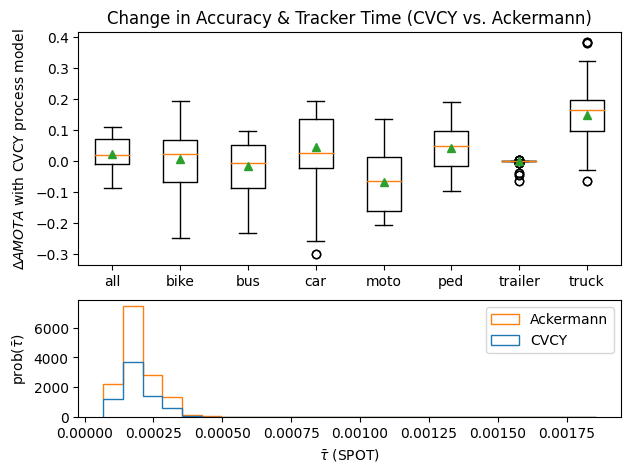

In [25]:
# Generate yaw_corr timing plot
n_bins=25
fig, axs = plt.subplots(2, 1, tight_layout=False, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

# axs[0].set_title('Change in Accuracy & Tracker Time (CVCY vs. Ackermann)')
# axs[0].boxplot(model_diff_df, labels=model_diff_df.columns, showmeans=True)
# axs[0].set_ylabel('$\Delta AMOTA$ with CVCY process model')
# axs[1].hist((cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000),ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)),histtype='step',density=True,stacked=True, bins=n_bins, label=['CVCY','Ackermann']) #, bins=n_bins
# # axs[1].set_title('Change in Tracker Loop Times')
# axs[1].set_ylabel('prob($\\bar{\\tau}$)')
# axs[1].set_xlabel('$\\bar{\\tau}$ (SPOT)')
# axs[1].legend()

print('cvcy')
print(np.mean(cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000)))
print(np.max(cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000)))
print(len(cvcy_time_df['time_ns']))
print(np.mean(cvcy_time_df['time_ns']/(1000000000)))
print(np.max(cvcy_time_df['time_ns']/(1000000000)))
print()

print('ackermann')
print(np.mean(ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)))
print(np.max(ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)))
print(len(ack_time_df['time_ns']))
print(np.mean(ack_time_df['time_ns']/(1000000000)))
print(np.max(ack_time_df['time_ns']/(1000000000)))
print()

print('change in amota')
print(np.mean(model_diff_df,axis=0))

# Final Plot 2: Increase in AMOTA, delta T for process model/matching/yaw corr selection

In [40]:
# Compute average and per-class AMOTA, plus mean/min FPS for yc vs. no YC

print('************* yc')
print("AMOTA - all: %s" % np.mean(yc_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(yc_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(yc_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(yc_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(yc_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(yc_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(yc_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(yc_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(yc_time_df['fps']))
print("Min FPS: %s" % np.min(yc_time_df['fps']))
print()

print('************* NO yc')
print("AMOTA - all: %s" % np.mean(noyc_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(noyc_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(noyc_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(noyc_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(noyc_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(noyc_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(noyc_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(noyc_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(noyc_time_df['fps']))
print("Min FPS: %s" % np.min(noyc_time_df['fps']))
print()

print('************* Hungarian')
print("AMOTA - all: %s" % np.mean(hungar_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(hungar_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(hungar_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(hungar_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(hungar_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(hungar_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(hungar_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(hungar_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(hungar_time_df['fps']))
print("Min FPS: %s" % np.min(hungar_time_df['fps']))
print()

print('************* Greedy')
print("AMOTA - all: %s" % np.mean(greedy_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(greedy_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(greedy_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(greedy_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(greedy_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(greedy_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(greedy_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(greedy_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(greedy_time_df['fps']))
print("Min FPS: %s" % np.min(greedy_time_df['fps']))
print()

print('************* CVCY (tracker)')
print("AMOTA - all: %s" % np.mean(cvcy_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(cvcy_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(cvcy_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(cvcy_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(cvcy_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(cvcy_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(cvcy_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(cvcy_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(cvcy_time_df['fps']))
print("Min FPS: %s" % np.min(cvcy_time_df['fps']))
print()

print('************* CVCY (obj)')
print("AMOTA - all: %s" % np.mean(cvcyobj_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(cvcyobj_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(cvcyobj_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(cvcyobj_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(cvcyobj_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(cvcyobj_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(cvcyobj_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(cvcyobj_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(cvcyobj_time_df['fps']))
print("Min FPS: %s" % np.min(cvcyobj_time_df['fps']))
print()

print('************* Ackermann')
print("AMOTA - all: %s" % np.mean(ack_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(ack_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(ack_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(ack_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(ack_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(ack_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(ack_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(ack_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(ack_time_df['fps']))
print("Min FPS: %s" % np.min(ack_time_df['fps']))
print()



************* yc
AMOTA - all: 0.48678104575163395
AMOTA - bike: 0.31944117647058823
AMOTA - bus: 0.592607843137255
AMOTA - car: 0.46921568627450977
AMOTA - moto: 0.2616274509803922
AMOTA - ped: 0.6141307189542483
AMOTA - trlr: 0.7740882352941177
AMOTA - truck: 0.3765588235294117
Mean FPS: 83.29408686711201
Min FPS: 7.076147019549873

************* NO yc
AMOTA - all: 0.487421568627451
AMOTA - bike: 0.3197483660130719
AMOTA - bus: 0.5929575163398693
AMOTA - car: 0.46926797385620916
AMOTA - moto: 0.26134967320261443
AMOTA - ped: 0.609235294117647
AMOTA - trlr: 0.7742385620915033
AMOTA - truck: 0.38516666666666666
Mean FPS: 83.689523429988
Min FPS: 6.958896622960203

************* Hungarian
AMOTA - all: 0.4605490196078431
AMOTA - bike: 0.3134313725490196
AMOTA - bus: 0.5755718954248367
AMOTA - car: 0.4080196078431373
AMOTA - moto: 0.24400000000000005
AMOTA - ped: 0.5733660130718954
AMOTA - trlr: 0.774029411764706
AMOTA - truck: 0.3354934640522876
Mean FPS: 87.72858094780791
Min FPS: 6.9588

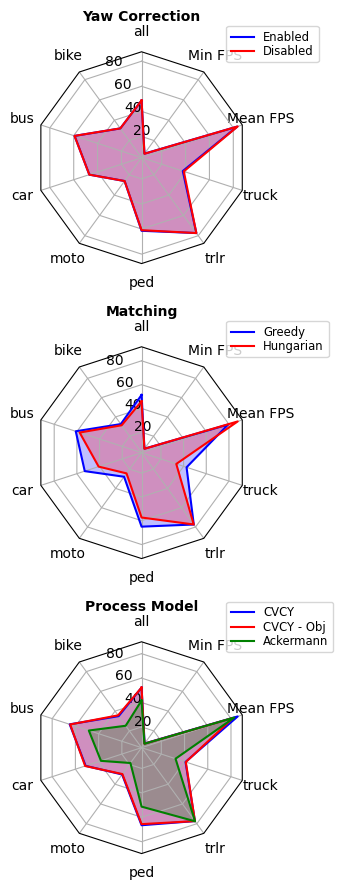

In [68]:
# RADAR PLOT
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



spoke_labels =['all','bike','bus','car','moto','ped','trlr','truck','Mean FPS','Min FPS']
yc_data = [[np.mean(yc_acc_df['amota'])*100,
             np.mean(yc_acc_df['bicycle_amota'])*100,
             np.mean(yc_acc_df['bus_amota'])*100,
             np.mean(yc_acc_df['car_amota'])*100,
             np.mean(yc_acc_df['moto_amota'])*100,
             np.mean(yc_acc_df['ped_amota'])*100,
             np.mean(yc_acc_df['trailer_amota'])*100,
             np.mean(yc_acc_df['truck_amota'])*100,
             np.mean(yc_time_df['fps']),
             np.min(yc_time_df['fps'])],
            [np.mean(noyc_acc_df['amota'])*100,
             np.mean(noyc_acc_df['bicycle_amota'])*100,
             np.mean(noyc_acc_df['bus_amota'])*100,
             np.mean(noyc_acc_df['car_amota'])*100,
             np.mean(noyc_acc_df['moto_amota'])*100,
             np.mean(noyc_acc_df['ped_amota'])*100,
             np.mean(noyc_acc_df['trailer_amota'])*100,
             np.mean(noyc_acc_df['truck_amota'])*100,
             np.mean(noyc_time_df['fps']),
             np.min(noyc_time_df['fps'])]]

match_data = [[np.mean(greedy_acc_df['amota'])*100,
             np.mean(greedy_acc_df['bicycle_amota'])*100,
             np.mean(greedy_acc_df['bus_amota'])*100,
             np.mean(greedy_acc_df['car_amota'])*100,
             np.mean(greedy_acc_df['moto_amota'])*100,
             np.mean(greedy_acc_df['ped_amota'])*100,
             np.mean(greedy_acc_df['trailer_amota'])*100,
             np.mean(greedy_acc_df['truck_amota'])*100,
             np.mean(greedy_time_df['fps']),
             np.min(greedy_time_df['fps'])],
             [np.mean(hungar_acc_df['amota'])*100,
             np.mean(hungar_acc_df['bicycle_amota'])*100,
             np.mean(hungar_acc_df['bus_amota'])*100,
             np.mean(hungar_acc_df['car_amota'])*100,
             np.mean(hungar_acc_df['moto_amota'])*100,
             np.mean(hungar_acc_df['ped_amota'])*100,
             np.mean(hungar_acc_df['trailer_amota'])*100,
             np.mean(hungar_acc_df['truck_amota'])*100,
             np.mean(hungar_time_df['fps']),
             np.min(hungar_time_df['fps'])]]

proc_model_data = [[np.mean(cvcy_acc_df['amota'])*100,
             np.mean(cvcy_acc_df['bicycle_amota'])*100,
             np.mean(cvcy_acc_df['bus_amota'])*100,
             np.mean(cvcy_acc_df['car_amota'])*100,
             np.mean(cvcy_acc_df['moto_amota'])*100,
             np.mean(cvcy_acc_df['ped_amota'])*100,
             np.mean(cvcy_acc_df['trailer_amota'])*100,
             np.mean(cvcy_acc_df['truck_amota'])*100,
             np.mean(cvcy_time_df['fps']),
             np.min(cvcy_time_df['fps'])],
             [np.mean(cvcyobj_acc_df['amota'])*100,
             np.mean(cvcyobj_acc_df['bicycle_amota'])*100,
             np.mean(cvcyobj_acc_df['bus_amota'])*100,
             np.mean(cvcyobj_acc_df['car_amota'])*100,
             np.mean(cvcyobj_acc_df['moto_amota'])*100,
             np.mean(cvcyobj_acc_df['ped_amota'])*100,
             np.mean(cvcyobj_acc_df['trailer_amota'])*100,
             np.mean(cvcyobj_acc_df['truck_amota'])*100,
             np.mean(cvcyobj_time_df['fps']),
             np.min(cvcyobj_time_df['fps'])],
             [np.mean(ack_acc_df['amota'])*100,
             np.mean(ack_acc_df['bicycle_amota'])*100,
             np.mean(ack_acc_df['bus_amota'])*100,
             np.mean(ack_acc_df['car_amota'])*100,
             np.mean(ack_acc_df['moto_amota'])*100,
             np.mean(ack_acc_df['ped_amota'])*100,
             np.mean(ack_acc_df['trailer_amota'])*100,
             np.mean(ack_acc_df['truck_amota'])*100,
             np.mean(ack_time_df['fps']),
             np.min(ack_time_df['fps'])]]
                             

N = 10
theta = radar_factory(N, frame='polygon')


fig, axs = plt.subplots(figsize=(4.5, 9), nrows=3, tight_layout=True,ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g']

# Yaw correction
axs[0].set_rgrids([20, 40, 60, 80])
axs[0].set_title('Yaw Correction', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')

for d, color in zip(yc_data, colors):
    axs[0].plot(theta, d, color=color)
    axs[0].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs[0].set_varlabels(spoke_labels)

legend = axs[0].legend(('Enabled', 'Disabled'), loc=(0.9, .95), labelspacing=0.1, fontsize='small')

# Matching
axs[1].set_rgrids([20, 40, 60, 80])
axs[1].set_title('Matching', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')

for d, color in zip(match_data, colors):
    axs[1].plot(theta, d, color=color)
    axs[1].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs[1].set_varlabels(spoke_labels)

legend = axs[1].legend(('Greedy', 'Hungarian'), loc=(0.9, .95), labelspacing=0.1, fontsize='small')

# Proc model
axs[2].set_rgrids([20, 40, 60, 80])
axs[2].set_title('Process Model', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')

for d, color in zip(proc_model_data, colors):
    axs[2].plot(theta, d, color=color)
    axs[2].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs[2].set_varlabels(spoke_labels)

legend = axs[2].legend(('CVCY', 'CVCY - Obj', 'Ackermann'), loc=(0.9, .95), labelspacing=0.1, fontsize='small')


plt.savefig('nuscenes_results_2.png')
plt.show()




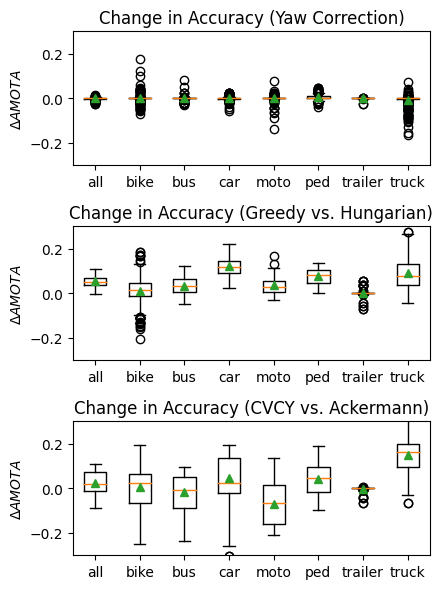

In [53]:
n_bins=20
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(4.5,6)) # , gridspec_kw={'height_ratios': [2, 1]}

axs[0].set_title('Change in Accuracy (Yaw Correction)')
axs[0].boxplot(yc_diff_df, labels=yc_diff_df.columns, showmeans=True)
axs[0].set_ylabel('$\Delta AMOTA$')
axs[0].set_ylim([-.3,.3])

axs[1].set_title('Change in Accuracy (Greedy vs. Hungarian)')
axs[1].boxplot(match_diff_df, labels=match_diff_df.columns, showmeans=True)
axs[1].set_ylabel('$\Delta AMOTA$')
axs[1].set_ylim([-.3,.3])

axs[2].set_title('Change in Accuracy (CVCY vs. Ackermann)')
axs[2].boxplot(model_diff_df, labels=model_diff_df.columns, showmeans=True)
axs[2].set_ylabel('$\Delta AMOTA$')
axs[2].set_ylim([-.3,.3])

plt.savefig('nuscenes_results_2.png')

In [57]:
print('yc')
print(np.mean(yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000)))
print(np.max(yc_time_df['time_ns']/(yc_time_df['n_max']*1000000000)))
print(len(yc_time_df['time_ns']))
print(np.mean(yc_time_df['time_ns']/(1000000000)))
print(np.max(yc_time_df['time_ns']/(1000000000)))
print()

print('no_yc')
print(np.mean(noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)))
print(np.max(noyc_time_df['time_ns']/(noyc_time_df['n_max']*1000000000)))
print(len(noyc_time_df['time_ns']))
print(np.mean(noyc_time_df['time_ns']/(1000000000)))
print(np.max(noyc_time_df['time_ns']/(1000000000)))
print()

print('change in amota when yc enabled')
print(np.mean(yc_diff_df,axis=0))
print('change in dt (avg)')
print(np.mean(yc_time_df['time_ns']/(1000000000) - np.mean(noyc_time_df['time_ns']/(1000000000))))
print('change in dt (max)')
print(np.max(yc_time_df['time_ns']/(1000000000)) - np.max(noyc_time_df['time_ns']/(1000000000)))
print()

print('greedy')
print(np.mean(greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000)))
print(np.max(greedy_time_df['time_ns']/(greedy_time_df['n_max']*1000000000)))
print(len(greedy_time_df['time_ns']))
print(np.mean(greedy_time_df['time_ns']/(1000000000)))
print(np.max(greedy_time_df['time_ns']/(1000000000)))
print()

print('hungarian')
print(np.mean(hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)))
print(np.max(hungar_time_df['time_ns']/(hungar_time_df['n_max']*1000000000)))
print(len(hungar_time_df['time_ns']))
print(np.mean(hungar_time_df['time_ns']/(1000000000)))
print(np.max(hungar_time_df['time_ns']/(1000000000)))
print()

print('change in amota')
print(np.mean(match_diff_df,axis=0))
print('change in dt (avg)')
print(np.mean(greedy_time_df['time_ns']/(1000000000) - np.mean(hungar_time_df['time_ns']/(1000000000))))
print('change in dt (max)')
print(np.max(greedy_time_df['time_ns']/(1000000000)) - np.max(hungar_time_df['time_ns']/(1000000000)))
print()

print('cvcy')
print(np.mean(cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000)))
print(np.max(cvcy_time_df['time_ns']/(cvcy_time_df['n_max']*1000000000)))
print(len(cvcy_time_df['time_ns']))
print(np.mean(cvcy_time_df['time_ns']/(1000000000)))
print(np.max(cvcy_time_df['time_ns']/(1000000000)))
print()

print('ackermann')
print(np.mean(ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)))
print(np.max(ack_time_df['time_ns']/(ack_time_df['n_max']*1000000000)))
print(len(ack_time_df['time_ns']))
print(np.mean(ack_time_df['time_ns']/(1000000000)))
print(np.max(ack_time_df['time_ns']/(1000000000)))
print()

print('change in amota')
print(np.mean(model_diff_df,axis=0))
print('change in dt (avg)')
print(np.mean(cvcy_time_df['time_ns']/(1000000000) - np.mean(ack_time_df['time_ns']/(1000000000))))
print('change in dt (max)')
print(np.max(cvcy_time_df['time_ns']/(1000000000)) - np.max(ack_time_df['time_ns']/(1000000000)))
print()

yc
0.00019632909154063927
0.0017622009555555555
98837
0.01854344097376489
0.141319845

no_yc
0.00019668563533419115
0.0018570565714285715
98837
0.018697817645608426
0.143700942

change in amota when yc enabled
all       -0.000641
bike      -0.000307
bus       -0.000350
car       -0.000052
moto       0.000278
ped        0.004895
trailer   -0.000150
truck     -0.008608
dtype: float64
change in dt (avg)
-0.00015437667184354059
change in dt (max)
-0.0023810969999999987

greedy
0.0002096342306674186
0.0018570565714285715
98837
0.019917181600645508
0.141975731

hungarian
0.00018338049620741183
0.0018085122
98837
0.017324077018727804
0.143700942

change in amota
all        0.053105
bike       0.012327
bus        0.034422
car        0.122444
moto       0.034977
ped        0.076634
trailer    0.000268
truck      0.090739
dtype: float64
change in dt (avg)
0.002593104581917703
change in dt (max)
-0.0017252110000000043

cvcy
0.0001921062279739547
0.0016780430222222223
65892
0.01813734463488739
0.1

# Final validation/test results

In [11]:
val_time_path = '../../results/3_testval/val/times.csv'
val_time_df = pd.read_csv(val_time_path)

for cfg in val_time_df['config'].unique():
    print(cfg)
    print("Mean comp time: %s" % (np.mean(val_time_df[val_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Max comp time: %s" % (np.max(val_time_df[val_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Mean FPS: %s" % (1000000000/np.mean(val_time_df[val_time_df['config']==cfg]['time_ns'])))
    print("Min FPS: %s" % (1000000000/np.max(val_time_df[val_time_df['config']==cfg]['time_ns'])))
    print()

greedy_dist5_bestmodel_conf_padd_15_yc
Mean comp time: 0.014773540593454064
Max comp time: 0.703225437
Mean FPS: 67.68858105978232
Min FPS: 1.4220190957057204

greedy_iou_bestmodel_conf_padd_15_yc
Mean comp time: 0.513537926109819
Max comp time: 4.513224479
Mean FPS: 1.9472758469374514
Min FPS: 0.22157107510450513

greedy_giou_bestmodel_conf_padd_15_yc
Mean comp time: 1.4135156891139724
Max comp time: 15.376351706
Mean FPS: 0.707455890091199
Min FPS: 0.06503493280592629



In [14]:
test_time_path = '../../results/3_testval/test/times.csv'
test_time_df = pd.read_csv(test_time_path)

for cfg in test_time_df['config'].unique():
    print(cfg)
    print("Mean comp time: %s" % (np.mean(test_time_df[test_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Max comp time: %s" % (np.max(test_time_df[test_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Mean FPS: %s" % (1000000000/np.mean(test_time_df[test_time_df['config']==cfg]['time_ns'])))
    print("Min FPS: %s" % (1000000000/np.max(test_time_df[test_time_df['config']==cfg]['time_ns'])))
    print()


greedy_dist5_bestmodel_conf_padd_15_yc
Mean comp time: 0.017052019396304928
Max comp time: 0.726026991
Mean FPS: 58.64408060764311
Min FPS: 1.377359261289502

greedy_giou_bestmodel_conf_padd_15_yc
Mean comp time: 1.9436498396233357
Max comp time: 16.78714798
Mean FPS: 0.5144959650724908
Min FPS: 0.05956938017055593

